# Speech Recognition using CDHMMs

In [20]:
import os
import MFCC
import re
import random
import scipy as sp
import numpy as np
import pandas as pd
from hmmlearn import hmm
from scipy.io import wavfile
from scipy.special import logsumexp
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pickle

## Problem 1

Write a function `sample_gmmhmm` which accepts an integer $T$, and draws $T$ samples from the GMMHMM given in the lab pdf.

Use your function to draw $T=900$ samples from the GMMHMM.
Use `sklearn.decomposition.PCA` with 2 components to plot the observations in two-dimensional space. 
Color the observations by state.
How many distinct clusters do you see?

Hint: the function `np.random.choice` will be useful for drawing the hidden states and the GMM components, and `np.random.multivariate_normal` for the observation sequence. 
When plotting the samples, using the keyword argument `c` in `plt.scatter` allows you to specify the colors of the individual points.

In [21]:
def sample_gmmhmm(T):
    """
    Simulate from the GMMHMM given in the problem, returning T samples.
    
    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, M)
        The generated observations (vectors of length M)
    """
    N = 3
    K = 5
    M = 4
    
    ## Define the GMMHMM parameters
    # NxN transition matrix 
    A = np.array([[.3, .3, .4], [.2, .3, .5], [.3, .2, .5]])
    # NxK collection of component weights
    weights = np.array([[.3, .2, .1, .2, .2], [.1, .3, .3, .2, .1], 
                        [.1, .3, .2, .1, .3]])
    # NxKxM collection of component means
    means = np.array([np.floor(np.random.uniform(-100, 100, size = (5, 4))) 
                            for i in range(3)])
    # NxKx(MxM) collection of component covariance matrices       
    covars = np.array([[np.floor(np.random.uniform(1, 20))*np.eye(4) 
                            for i in range(5)] for j in range(3)])
    # (N,) ndarray initial state distribution 
    pi = np.array([.15, .15, .7])
    
    raise NotImplementedError("Problem 1 incomplete")

In [22]:
def sample_gmmhmm(T):
    """
    Simulate from the GMMHMM given in the problem, returning T samples.
    
    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, M)
        The generated observations (vectors of length M)
    """
    # Define the dimensions of the GMMHMM
    N = 3  # Number of states
    K = 5  # Number of mixture components
    M = 4  # Dimensionality of the observation space

    # Define the GMMHMM parameters
    # Transition matrix: NxN
    A = np.array([[.3, .3, .4], [.2, .3, .5], [.3, .2, .5]])

    # Collection of component weights: NxK
    weights = np.array([[.3, .2, .1, .2, .2], [.1, .3, .3, .2, .1], 
                        [.1, .3, .2, .1, .3]])

    # Collection of component means: NxKxM
    means = np.array([np.floor(np.random.uniform(-100, 100, size=(5, 4))) 
                    for i in range(3)])

    # Collection of component covariance matrices: NxKx(MxM)
    covars = np.array([[np.floor(np.random.uniform(1, 20)) * np.eye(4) 
                        for i in range(5)] for j in range(3)])

    # Initial state distribution: (N,)
    pi = np.array([.15, .15, .7])

    # Lists to store states and observations
    states = []
    obs = []

    # Initialize the first state from the initial distribution pi
    state = np.argmax(np.random.multinomial(1, pi))

    # Iterate through the number of samples
    for i in range(T):
        states.append(state)

        # Sample a mixture component based on the weights of the current state
        sample_component = np.argmax(np.random.multinomial(1, weights[state, :]))
        
        # Sample an observation from the selected mixture component
        sample = np.random.multivariate_normal(means[state, sample_component, :], 
                                            covars[state, sample_component, :, :])
        
        obs.append(sample)

        # Transition to the next state based on the transition matrix A
        state = np.argmax(np.random.multinomial(1, A[:, state]))

    # Perform PCA to reduce the dimensionality of the observations to 2
    pca = PCA(n_components=2)
    pca.fit(obs)
    obs = pca.transform(obs)

    # Plot the observations colored by their corresponding states
    plt.scatter(obs[:, 0], obs[:, 1], c=states)
    plt.show()


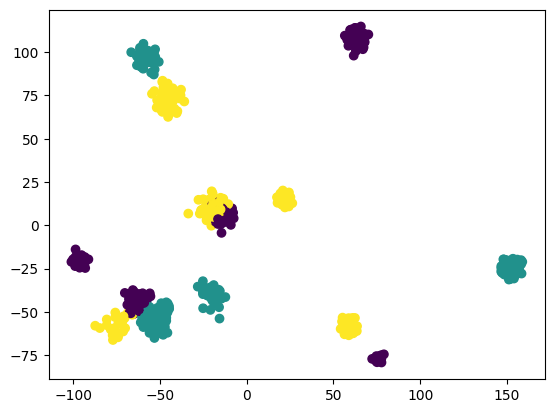

In [23]:
sample_gmmhmm(900)

## Problem 2

In the remainder of this lab, we will create a speech recognition system for the vocabulary of the following five words/phrases: "biology", "mathematics", "political science", "psychology", and "statistics".

The `Samples` folder contains 30 recordings for each of the words/phrases in the vocabulary.
These audio samples are 2 seconds in duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed integers in WAV format. 
For each of the words, create a list holding the MFCC coefficients of the recordings of that word.

The function `scipy.io.wavfile.read` can be used to load the sound files, and the function `extract` in `MFCC.py` implements the MFCC coefficient algorithm.

In [24]:
# Define the categories and lists to store the data
bio = []
math = []
poli_sci = []
psych = []
stats = []

# Load the data from the samples directory and extract the MFCC features
wav_dir = os.path.join(os.getcwd(),'Samples')
for audiofile in os.listdir(wav_dir):
    
    # Load the data and extract the MFCC features
    sample_rate, data= wavfile.read(os.path.join(wav_dir, audiofile))
    extracted_data = MFCC.extract(data)
    
    # Append the extracted data to the corresponding category list
    for audio_list, category in zip([bio, math, poli_sci, psych, stats],
                        ['Biology', 'Math', 'Poli', 'Psych', 'Stat']):
        
        # Check if the category is in the audio file name
        if category in audiofile:
            audio_list.append(extracted_data)

C:\Users\benja\AppData\Local\Temp\ipykernel_3452\1075799294.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data= wavfile.read(os.path.join(wav_dir, audiofile))


In [25]:
print(len(bio), len(math), len(poli_sci), len(psych), len(stats))

30 30 30 30 30


## Problem 3

For each word, randomly split the list of MFCCs into a training set of 20 samples and a test set of the remaining 10 samples.

Use the training sets to train GMMHMMs on each word in the vocabulary.
For each word in the vocabulary, train 10 GMMHMMs on the training set, using `n_components=5`.
Keep the model with the highest log-likelihood for each word.

In [26]:
# Split the data into training and testing sets
train_size = 20
test_size = 10
biology_train, biology_test = train_test_split(bio, test_size=test_size, train_size=train_size)
math_train, math_test = train_test_split(math, test_size=test_size, train_size=train_size)
political_science_train, political_science_test = train_test_split(poli_sci, test_size=test_size, train_size=train_size)
psychology_train, psychology_test = train_test_split(psych, test_size=test_size, train_size=train_size)
statistics_train, statistics_test = train_test_split(stats, test_size=test_size, train_size=train_size)

# Store the best models for each category
best_models = {'Biology':None,
                'Math':None,
                'Poli':None,
                'Psych':None,
                'Stat':None}

# Train the models for each category
for data, label in zip([biology_train, math_train, political_science_train, psychology_train, statistics_train],
                       ['Biology', 'Math', 'Poli', 'Psych', 'Stat']):
    logprob = -np.inf
    
    # Train the model 10 times and store the best one based on the logprob
    for _ in range(10):
        model = hmm.GMMHMM(n_components=5, covariance_type="diag", init_params="mc") 
        model.fit(np.vstack(data))

        # Store the best model and reset the logprob if a better model is found 
        if model.monitor_.history[-1] > logprob:
            logprob = model.monitor_.history[-1]
            best_model = model

    # Store the best model for the category
    best_models[label] = best_model


## Problem 4

Write a `predict` function for your speech recognition model.
In this function:
 - Accept the MFCC coefficients of the speech sample to be predicted.
 - Find the log probability density of the coefficients for each word's GMMHMM.
 - Return the word with the highest probability as the speech recognition model's prediction.

In [27]:
def predict(model, data):
    """
    Predict the label of the given data using the given model.
    """

    # Get the score of the data given the model
    words = list(best_models.keys())

    # Get the score of the data given the model
    scores=[]
    for _, model in best_models.items():
        scores.append(model.score(data))

    # Return the word with the highest score
    return words[np.argmax(scores)]

## Problem 5

For each of the five test sets, call your `predict` function on each sample, and find the proportion of each test set that your model predicts correctly.
Display your results.
How well does your model perform on this dataset?

In [28]:
results = pd.DataFrame(columns=['Category', 'Prediction'])

# For each test set
for data, label in zip([biology_test, math_test, political_science_test, psychology_test, statistics_test],
                       ['Biology', 'Math', 'Poli', 'Psych', 'Stat']):
    # For each data point
    for i, d in enumerate(data):
        # Predict the label using the predict function
        pred = predict(best_models, d)
        
        # Concatenate the results
        results = pd.concat([results, pd.DataFrame(columns=['Category', 'Prediction'], 
                                                   data=[[label, pred]])])
    
# For each category, print the accuracy
for category in ['Biology', 'Math', 'Poli', 'Psych', 'Stat']:
    print(category, 'Accuracy:', np.mean(results[results['Category'] == category]['Category'] == 
                                          results[results['Category'] == category]['Prediction']))

Biology Accuracy: 1.0
Math Accuracy: 1.0
Poli Accuracy: 1.0
Psych Accuracy: 0.9
Stat Accuracy: 1.0


The model performs well on all categories! I ran it a few times and occasionaly one will be less accurate but they tend to have a high average accuracy.